# In this project, I analyze a dataset containing restaurant reviews and whether they are positive or negative. From this, I will conduct sentiment analysis to teach the program to predict whether a review is positive or negative. The program can often predict with 80% accuracy. 

#### This project is based on the following guide: https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6. 

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt, figure
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt    


# The first thing we should analyze is the most common words used in these reviews. As we can see, the most common words in all reviews are 'good','place' and 'food'. In positive reviews, they are 'food', 'great', and 'good'. In negative reviews, they are 'back','place', and 'food'.

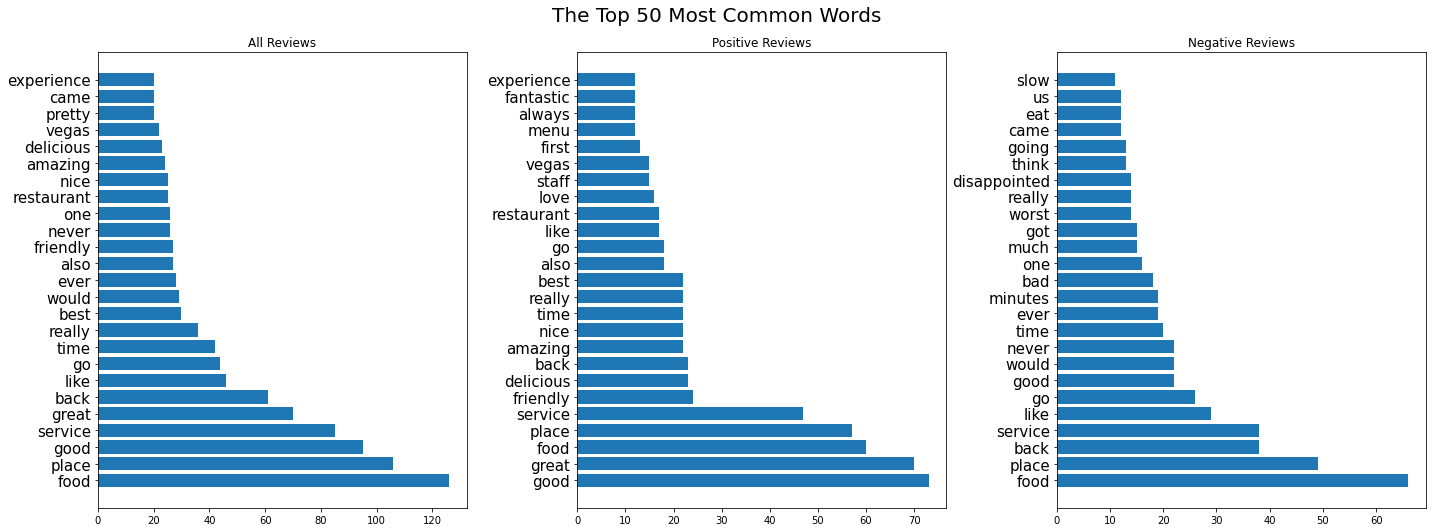

In [2]:
# Creating the data frame
reviews=pd.read_csv(os.path.join(os.getcwd(), "Restaurant_Reviews.csv"))
stop = set(stopwords.words('english'))
#Creating a figure with three subplots to display the most common words in positive, negative, and all reviews.
fig, common_axs = plt.subplots(1, 3,figsize=(20,7.5)) 
fig.suptitle("The Top 50 Most Common Words", fontsize=20)
def common_bar(df,position,review_type): #position indicates which subplot the graph will be plotted on. 
    #The next 6 lines of code are from https://www.kaggle.com/edhirif/word-cloud-alternative-using-nltk
    review_str = df["Review"].str.cat(sep = ' ') #Takes each row of the reviews dataframe and puts it into a single string. Each review is separated with a space.
    list_of_words = [i.lower() for i in wordpunct_tokenize(review_str) if i.lower() not in stop and i.isalpha()] #Lowercases each word in every review if it is not in the list of stop words and all the characters in the word are letters.
    wordfreqdist = nltk.FreqDist(list_of_words)#Counts how frequent each word is.
    mostcommon = wordfreqdist.most_common(25) #creates a list of the 25 most common words.
    common_axs[position].barh(range(len(mostcommon)),[val[1] for val in mostcommon])
    common_axs[position].set_title(review_type + ' Reviews')
    plt.sca(common_axs[position])
    plt.yticks(range(len(mostcommon)),[val[0] for val in mostcommon],fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(wspace=.30)
common_bar(reviews,0,"All") 
common_bar(reviews[reviews["Liked"]==1],1,"Positive")
common_bar(reviews[reviews["Liked"]==0],2,"Negative")
plt.show()


### The next step is to clean the data by removing punctuation from the reviews. 

In [3]:
def remove_punctuation(text): ##Replaces punctuation with an empty string.
    final = "".join(char for char in text if char not in ("?", ".", ";", ":",  "!",'"')) #Joins together each character in the text if it is not punctuation. 
    return final
reviews["Review"]=reviews["Review"].apply(remove_punctuation)
reviews = reviews.dropna(subset=['Review'])
reviews

,Review,Liked
0,Wow Loved this place,1
1,Crust is not good,0
2,Not tasty and the texture was just nasty,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone,0
997,Overall I was not impressed and would not go back,0
998,"The whole experience was underwhelming, and I ...",0


## A note on the next cell. 
    In the previous cell, there is a 2D array. Every row in the data frame is recorded as a separate list in the array. A data frame of 100 rows would have an array of 100 lists. Each list contains a series of numbers, one for each unique word found in the data frame. If there are 50 unique words in the data frame, then each series in each list of the array would have 50 entries. If the data frame has 100 rows and 50 unique words, then there would be 100 lists, and each list would have 50 entries. 
    For every entry in each list, there is a number representing how many times each of the unique words appears in the row corresponding to that list. If one of the unique words is 'hello' and the first row contains the following string: "hi my name is michael" then the entry for 'hello' in the first list would be 0 as 'hello' does not appear in the first row. The entries for 'hi' 'my', 'name', 'is', and 'michael' would all be 1's in the first list as each of them appear once.
    If we wanted to know which entry corresponds with which number (which word is the 2nd entry of every list for example), we could simply print (vectorizer.get_feature_names()). This will return a list of words, and the index of each word in the list corresponds with the index of each entry in the array. I have printed the last 10 words in the list above. The last word is "zero" so the last entry of each list in the array will have a number denoting how many times "zero" appears in that row.


In [4]:
X_train,X_test,y_train,y_test=train_test_split(reviews["Review"],reviews["Liked"],test_size=.2) #Splitting the dataset into testing and training datasets.
#X_train and X_test are the reviews; y_train and y_test are the numbers indicating the sentiment of each review. 
vectorizer = CountVectorizer(token_pattern=r'\w+') #Creates a vectorizer object which will count the frequency of each word.
train_matrix=vectorizer.fit_transform(X_train)
test_matrix=vectorizer.transform(X_test)
#The next three print statements are meant to help explain the note above.
print (train_matrix.toarray())
print (vectorizer.get_feature_names()[-10:])


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
['yelpers', 'yet', 'you', 'your', 'yourself', 'yucky', 'yukon', 'yum', 'yummy', 'zero']


# Now that the data is cleaned and formatted, teach the program to make predictions based on the reviews from the testing dataset.

In [5]:
lr = LogisticRegression()
lr.fit(train_matrix,y_train)
predictions = lr.predict(test_matrix)#This is an array of the predicted values for the testing datset.

# The program has made its predictions, so we can examine how well it did below. 

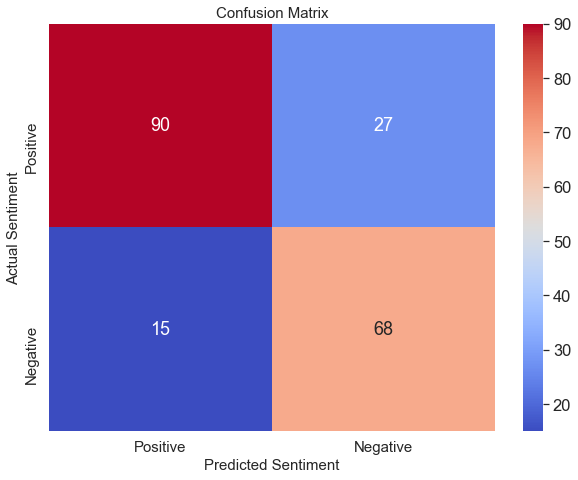

In [9]:
cm=confusion_matrix(y_test,predictions)
#The code used to create the confusion matrix is from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
fig, ax= plt.subplots(figsize=(10,7.5))
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, cmap="coolwarm",annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted Ssentiment', fontsize=15);ax.set_ylabel('Actual Sentiment',fontsize=15); 
ax.set_title('Confusion Matrix',fontsize=15); 
ax.xaxis.set_ticklabels(['Positive', 'Negative'],fontsize=15); ax.yaxis.set_ticklabels(['Positive', 'Negative'],fontsize=15);
plt.show()


In [7]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       117
           1       0.72      0.82      0.76        83

    accuracy                           0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.80      0.79      0.79       200

